# 6b. Graph Analytics

# 6b.1 Import Libraries

In [0]:
# %pip install graphframes
from graphframes import GraphFrame

In [0]:
from pyspark.sql.functions import lit, col, desc, format_number, abs, isnan, to_date, rand, length, count, when, hour, dayofweek, round, explode, lower, udf, mean, avg, stddev, min, max, coalesce, concat_ws, row_number, monotonically_increasing_id, floor, round as spark_round

from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, BucketedRandomProjectionLSH
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window
from pyspark.sql.types import NumericType
from pyspark.sql.functions import countDistinct

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer
from functools import reduce

import re

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("Graph_Analytics").getOrCreate()

# 6b.2 Import Df

In [0]:
# Import df_eda
df = spark.read.format("delta").load("/dbfs/FileStore/tables/df_graph")

# Display result
df.limit(10).display()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SEASON,SCHEDULED_DEPARTURE_PERIOD,IS_WEEKEND,ROUTE,SCHEDULED_DEPARTURE_min,SCHEDULED_ARRIVAL_min,DEPARTURE_TIME_min,WHEELS_OFF_min,ARRIVAL_TIME_min,TOTAL_FLIGHT_MIDNIGHT_min,CROSSES_MIDNIGHT_FLAG
2015,12,19,6,EV,5042,N850AS,22,15,87,86,63,377.0,1226,8,1234,21,0,0,0,0,5,16,0,ILM,ATL,Winter,Morning,1,ILM_ATL,646,733,668,683,754,731,0
2015,12,10,4,AA,1941,N752US,68,12,70,55,39,185.0,924,4,928,53,0,0,0,0,53,0,0,ILM,CLT,Winter,Early Morning,0,ILM_CLT,445,515,513,525,568,552,0
2015,12,3,4,EV,5106,N923EV,220,16,90,96,67,377.0,1943,13,1956,226,0,0,6,0,220,0,0,ILM,ATL,Winter,Afternoon,0,ILM_ATL,880,970,1100,1116,1196,1167,0
2015,11,29,7,EV,5239,N843AS,15,13,91,93,68,377.0,1941,12,1953,17,0,0,2,0,0,15,0,ILM,ATL,Autumn,Evening,1,ILM_ATL,1085,1176,1100,1113,1193,1168,0
2015,11,9,1,EV,4870,N858AS,10,8,91,97,69,377.0,1932,20,1952,16,0,0,6,0,1,9,0,ILM,ATL,Autumn,Evening,0,ILM_ATL,1085,1176,1095,1103,1192,1164,0
2015,11,6,5,AA,1821,N754UW,0,30,70,87,50,185.0,1550,7,1557,17,0,0,17,0,0,0,0,ILM,CLT,Autumn,Afternoon,0,ILM_CLT,870,940,870,900,957,920,0
2015,5,18,1,EV,5245,N936EV,106,9,89,81,62,377.0,1547,10,1557,98,0,0,0,0,60,38,0,ILM,ATL,Spring,Midday,0,ILM_ATL,770,859,876,885,957,938,0
2015,4,10,5,EV,4955,N852AS,72,13,88,84,63,377.0,1623,8,1631,68,0,0,0,0,0,68,0,ILM,ATL,Spring,Midday,0,ILM_ATL,835,923,907,920,991,970,0
2015,3,29,7,DL,1969,N944DL,58,9,94,78,59,377.0,931,10,941,42,0,0,0,0,42,0,0,ILM,ATL,Spring,Early Morning,1,ILM_ATL,445,539,503,512,581,562,0
2015,9,24,4,EV,2608,N687JS,3,12,57,88,30,140.0,1110,46,1156,34,0,0,31,0,3,0,0,LAW,DFW,Autumn,Morning,0,LAW_DFW,625,682,628,640,716,658,0


In [0]:
df.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- DIVERTED: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- AIR_SYSTEM_DELAY: integer (nullable = true)
 |-- SECURITY_DELAY: integer (nullable = true)
 |-- AIRLINE_DELAY: integer (nullable = true)
 |-- LATE_AIRCRAFT_DELAY: integer (nullable = true)


In [0]:
print(f"Total rows: {df.count()}")

Total rows: 43174


# 6b.3 Filter Out Cancelled and Diverted Flights 

In [0]:
# Filter out cancelled and diverted flights (and drop these columns)
df = df.filter(
    (col("CANCELLED") == 0) & (col("DIVERTED") == 0)
).drop("CANCELLED", "DIVERTED")

# 6b.4 Define Vertices, Edges, GraphFrame

In [0]:
# Vertices: Unique airports
vertices = (
    df.select(col("ORIGIN_AIRPORT").alias("id"))
    .union(df.select(col("DESTINATION_AIRPORT").alias("id")))
    .distinct()
)

# Edges: Flights between airports
edges = (
    df.groupBy("ORIGIN_AIRPORT", "DESTINATION_AIRPORT")
      .agg(
          count("*").alias("flight_count"),
          avg("DEPARTURE_DELAY").alias("avg_dep_delay"),
          avg("ARRIVAL_DELAY").alias("avg_arr_delay")
      )
      .withColumnRenamed("ORIGIN_AIRPORT", "src")
      .withColumnRenamed("DESTINATION_AIRPORT", "dst")
)

# Create the GraphFrame
airport_graph = GraphFrame(vertices, edges)

/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


# 6b.5 Explore the Graph

In [0]:
# In-Degree & Out-Degree
airport_graph.inDegrees.orderBy(col("inDegree").desc()).show()
airport_graph.outDegrees.orderBy(col("outDegree").desc()).show()

/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+--------+
| id|inDegree|
+---+--------+
|ATL|     151|
|DFW|     144|
|ORD|     143|
|DEN|     127|
|IAH|     110|
|MSP|      99|
|DTW|      97|
|EWR|      77|
|SFO|      73|
|LAX|      73|
|SLC|      73|
|LAS|      69|
|PHX|      69|
|MCO|      66|
|BWI|      63|
|MDW|      63|
|SEA|      61|
|TPA|      57|
|FLL|      57|
|CLT|      56|
+---+--------+
only showing top 20 rows

+---+---------+
| id|outDegree|
+---+---------+
|ORD|      157|
|ATL|      147|
|DFW|      146|
|DEN|      130|
|IAH|      107|
|MSP|      102|
|DTW|       90|
|EWR|       76|
|PHX|       76|
|LAX|       75|
|SFO|       74|
|LAS|       72|
|SLC|       72|
|MCO|       68|
|BWI|       65|
|MDW|       65|
|SEA|       63|
|CLT|       62|
|JFK|       59|
|LGA|       58|
+---+---------+
only showing top 20 rows



In [0]:
# PageRank (importance of hubs)
pagerank_results = airport_graph.pageRank(resetProbability=0.15, maxIter=10)

pagerank_results.vertices \
    .withColumn("pagerank", format_number("pagerank", 4)) \
    .orderBy("pagerank", ascending=False) \
    .show(truncate=False)

+---+--------+
|id |pagerank|
+---+--------+
|MSP|7.9265  |
|IAH|7.9168  |
|DTW|7.5602  |
|SLC|5.9901  |
|SFO|5.9205  |
|LAX|5.2699  |
|EWR|4.8974  |
|PHX|4.8156  |
|SEA|4.6826  |
|LAS|4.5118  |
|MCO|4.2318  |
|BWI|3.9328  |
|MDW|3.8906  |
|JFK|3.8287  |
|FLL|3.7214  |
|TPA|3.5142  |
|CLT|3.5012  |
|LGA|3.3046  |
|BOS|3.2195  |
|MIA|3.1022  |
+---+--------+
only showing top 20 rows



In [0]:
# Top delayed routes
edges \
  .withColumn("avg_arr_delay", format_number(col("avg_arr_delay"), 2)) \
  .withColumn("avg_dep_delay", format_number(col("avg_dep_delay"), 2)) \
  .orderBy(col("avg_arr_delay").desc()) \
  .show(truncate=False)

+---+---+------------+-------------+-------------+
|src|dst|flight_count|avg_dep_delay|avg_arr_delay|
+---+---+------------+-------------+-------------+
|ATL|MSN|6           |114.33       |99.50        |
|MOB|ORD|2           |51.00        |99.50        |
|ACY|ATL|6           |93.50        |99.50        |
|MHT|ORD|5           |107.40       |99.40        |
|ATL|GRB|3           |117.00       |99.33        |
|SIT|KTN|4           |103.25       |99.25        |
|EUG|SLC|2           |114.50       |99.00        |
|KTN|JNU|1           |97.00        |99.00        |
|IAH|MTJ|1           |133.00       |99.00        |
|AEX|DFW|11          |97.45        |98.45        |
|ABE|ATL|5           |89.00        |98.40        |
|OKC|SLC|5           |102.80       |98.00        |
|PNS|ATL|14          |98.93        |97.79        |
|CVG|DEN|13          |101.31       |97.77        |
|ISP|TPA|4           |119.25       |97.75        |
|MYR|PHL|6           |98.33        |97.67        |
|ROA|ATL|11          |91.91    

# 6b.6 Visualize the Graph

In [0]:
# vertices_pdf = pagerank_results.vertices.select("id").toPandas()
# edges_pdf = edges.select("src", "dst", "avg_arr_delay").toPandas()

In [0]:
# %pip install pyvis

In [0]:
# from pyvis.network import Network

# # Create Pyvis Network
# net = Network(notebook=True, height="750px", width="100%")

# # Add nodes (airports)
# for _, row in vertices_pdf.iterrows():
#     net.add_node(row['id'], label=row['id'])

# # Add edges (flights between airports)
# for _, row in edges_pdf.iterrows():
#     net.add_edge(row['src'], row['dst'], title=f"Avg Arr Delay: {row['avg_arr_delay']:.2f}")

# # Display the graph
# net.show("airport_network.html")

In [0]:
# displayHTML(open("airport_network.html").read())

# 6b.7 More Visualizations

Visualize Top Airport Hubs by PageRank

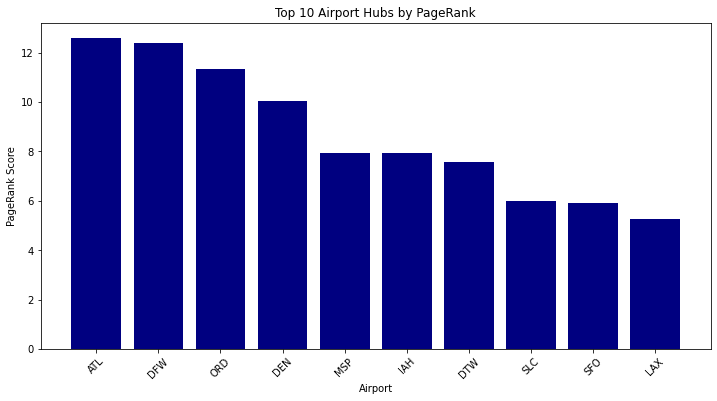

In [0]:
# Collect top 10 airports by pagerank
top_airports = pagerank_results.vertices \
    .orderBy("pagerank", ascending=False) \
    .limit(10) \
    .select("id", "pagerank") \
    .toPandas()

# Plot
plt.figure(figsize=(12,6))
plt.bar(top_airports['id'], top_airports['pagerank'], color='navy')
plt.title('Top 10 Airport Hubs by PageRank')
plt.xlabel('Airport')
plt.ylabel('PageRank Score')
plt.xticks(rotation=45)
plt.show()

Plot In-Degree and Out-Degree for Top Airports

/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
<command-1336967028028441>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(in_deg['id'], rotation=45)
<command-1336967028028441>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(out_deg['id'], rotation=45)


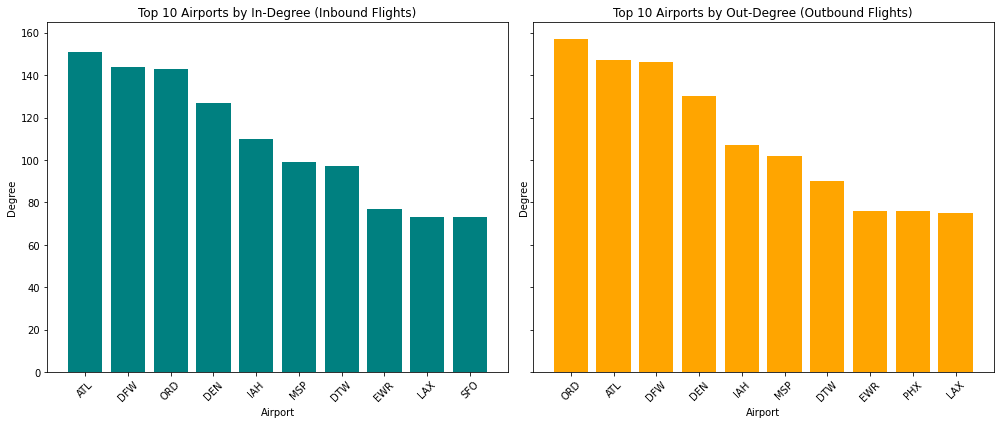

In [0]:
# Get top 10 airports by in-degree and out-degree
in_deg = airport_graph.inDegrees.orderBy("inDegree", ascending=False).limit(10).toPandas()
out_deg = airport_graph.outDegrees.orderBy("outDegree", ascending=False).limit(10).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

axes[0].bar(in_deg['id'], in_deg['inDegree'], color='teal')
axes[0].set_title('Top 10 Airports by In-Degree (Inbound Flights)')
axes[0].set_xticklabels(in_deg['id'], rotation=45)

axes[1].bar(out_deg['id'], out_deg['outDegree'], color='orange')
axes[1].set_title('Top 10 Airports by Out-Degree (Outbound Flights)')
axes[1].set_xticklabels(out_deg['id'], rotation=45)

for ax in axes:
    ax.set_xlabel('Airport')
    ax.set_ylabel('Degree')

plt.tight_layout()
plt.show()

Heatmap of Average Arrival Delays for Top Routes

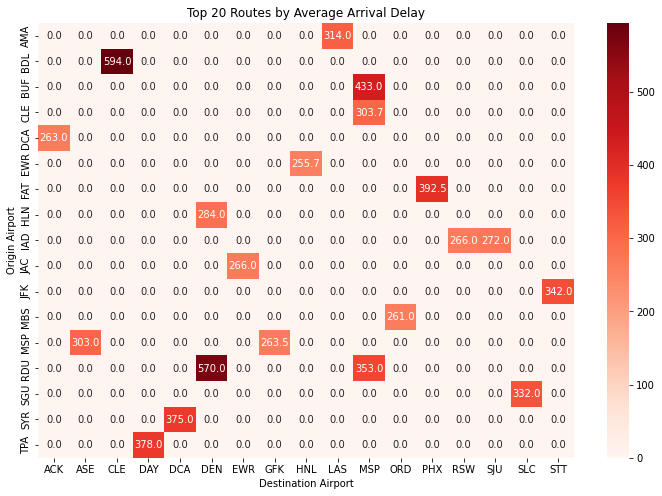

In [0]:
# Get top 20 routes with highest avg_arr_delay
top_routes = edges.orderBy(col("avg_arr_delay").desc()).limit(20).toPandas()

# Create a pivot table for heatmap (Origin vs Destination)
heatmap_data = top_routes.pivot("src", "dst", "avg_arr_delay").fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Reds")
plt.title('Top 20 Routes by Average Arrival Delay')
plt.xlabel('Destination Airport')
plt.ylabel('Origin Airport')
plt.show()